In [11]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.providers.aer import Aer
from qiskit.quantum_info import random_clifford
import random

import galois
import numpy as np
from matplotlib import pyplot as plt
GF = galois.GF(2)

In [2]:
n_qubits = 20
T = 50
qr = QuantumRegister(n_qubits, 'q')
cr = ClassicalRegister(n_qubits, 'c')
circ = QuantumCircuit(qr, cr)
p = 0.05

for t in range(T):
    for i in range(n_qubits // 2):
        circ.append(random_clifford(2), [qr[2*i], qr[2*i+1]])
    
    for i in range(n_qubits):
        if random.random() < p:
            circ.measure(qr[i], cr[i])
    
    circ.save_state(pershot = True, label = "t"+str(2*t))

    for j in range((n_qubits - 1) // 2):
        circ.append(random_clifford(2), [qr[2*j+1], qr[2*j+2]])
    
    if n_qubits % 2 == 0:
        circ.append(random_clifford(2), [qr[-1], qr[0]])
    
    for j in range(n_qubits):
        if random.random() < p:
            circ.measure(qr[j], cr[j])

    circ.save_state(pershot = True, label = "t"+str(2*t+1))

In [3]:
style = {
    'displaytext': {
        'clifford': r'\mathbf{C}_2'
    }
}

# circ.draw('mpl', style = style, plot_barriers = False)

In [4]:
simulator = Aer.get_backend('aer_simulator_stabilizer')
circ = transpile(circ, simulator)
result = simulator.run(circ, shots = 1000).result()

In [5]:
def B(G):
    rv = []
    for i in range(n_qubits): # loop through rows
        l = np.inf
        r = -np.inf
        for j in range(n_qubits): # loop through columns
            if G[i, 2*j] == 1 or G[i, 2*j+1] == 1:
                l = min(l, j)
                r = max(r, j)
        rv.append((l, r))
    return np.array(rv)

In [6]:
def clipped_gauge(stab_state):
    cliff = stab_state.clifford
    tableau = GF(cliff.stab.astype(int))[:, :-1]
    # Convert from X|Z to xz...xz, and convert to standard order
    stab = np.empty_like(tableau)
    stab[:, 0::2] = tableau[:, n_qubits-1::-1]
    stab[:, 1::2] = tableau[:, :n_qubits-1:-1]
    # Pregauge transformation
    stab = stab.row_reduce()
    # Gauge transformation (TODO)
    rev = stab[::-1, ::-1]
    rowset = set()
    for j in range(2 * n_qubits):
        col = rev[:, j]
        rows = np.nonzero(col)[0]
        if len(rows) == 0:
            continue
        if len(rows) == 1:
            rowset.add(rows[0])
            continue
        for i, row in enumerate(rows):
            if row not in rowset:
                rowset.add(row)
                if i != len(rows) - 1:
                    rev[rows[i+1:],:] += rev[row,:]
    return rev[::-1, ::-1]

In [17]:
def entropy(stab_state, A):
    cliff = stab_state.clifford
    tableau = GF(cliff.stab.astype(int))[:, :-1]
    # Convert from X|Z to xz...xz, and convert to standard order
    stab = np.empty_like(tableau)
    stab[:, 0::2] = tableau[:, n_qubits-1::-1]
    stab[:, 1::2] = tableau[:, :n_qubits-1:-1]

    return np.linalg.matrix_rank(stab[:,:2*A]) - A

In [18]:
stabs = result.data()['t99']

In [21]:
S = [entropy(stab_state, 10) for stab_state in stabs]

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5]),
 <BarContainer object of 10 artists>)

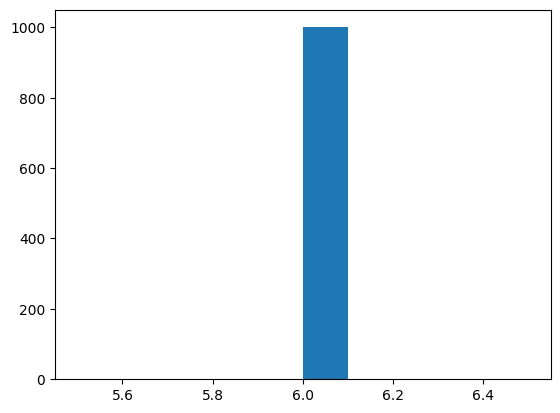

In [22]:
plt.hist(S)